In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle
import bz2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn

np.random.seed(123)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import dataset which includes image features from CNN.

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/Real_Estate_VIS_features_S14a_2023/features.pkl', 'rb') as file: #dataset provided by Zona
       con_data_all = pickle.load(file)
con_data_all.fillna(-1, inplace=True)
print("data shape: ", con_data_all.shape)
con_data_all.head()

data shape:  (40936, 2086)


,MLSNUM,LISTPRICE,SOLDPRICE,DOM,DTO,AGE,LOTSIZE,GARAGE,LISTMONTH,SOLDMONTH,...,resnet_2038,resnet_2039,resnet_2040,resnet_2041,resnet_2042,resnet_2043,resnet_2044,resnet_2045,resnet_2046,resnet_2047
0,71498924,169900.0,177500.0,709,618.0,11.0,-1.0,2.0,3,1,...,0.189716,0.112382,0.940322,0.104880,0.147426,0.343115,1.129136,0.181388,0.314849,0.385144
1,71905628,242000.0,235000.0,91,81.0,14.0,-1.0,1.0,9,1,...,0.189537,0.097927,2.036207,0.169374,0.386018,0.159283,0.267450,1.027563,0.218744,0.273669
2,71918879,209000.0,209000.0,78,37.0,32.0,-1.0,0.0,10,1,...,0.054234,0.028724,0.801957,0.303854,0.065759,0.098864,0.784945,1.562056,0.183976,0.415394
3,71952614,339900.0,350695.0,1,1.0,3.0,-1.0,1.0,1,1,...,0.149968,0.252659,2.011606,0.069289,0.159074,0.057379,1.281780,0.975176,0.233389,0.804610
4,71912071,299900.0,280000.0,83,71.0,10.0,-1.0,1.0,9,2,...,0.091527,0.222217,1.062608,0.104116,0.112099,0.135850,1.107761,0.381154,0.143897,0.390986


In [4]:
con_data_all.columns[:40]

Index(['MLSNUM', 'LISTPRICE', 'SOLDPRICE', 'DOM', 'DTO', 'AGE', 'LOTSIZE',
       'GARAGE', 'LISTMONTH', 'SOLDMONTH', 'LAT', 'LNG', 'beds', 'baths',
       'sqft_unfinished', 'stories', 'year_built', 'year_renovated',
       'parking_space', 'garage_space', 'hoa_fee',
       'school_ratings_elementary_avg', 'school_number_elementary',
       'school_distances_elementary_max', 'school_distances_elementary_min',
       'school_ratings_middle_avg', 'school_number_middle',
       'school_distances_middle_max', 'school_distances_middle_min',
       'school_ratings_high_avg', 'school_number_high',
       'school_distances_high_max', 'school_distances_high_min', 'walk_score',
       'transit_score', 'bike_score', 'num_photo', 'sqft_finished', 'resnet_0',
       'resnet_1'],
      dtype='object')

In [5]:
data = con_data_all[['SOLDPRICE','AGE','LOTSIZE','GARAGE','LAT','LNG','beds','baths','sqft_finished']].copy()

data.info(verbose=True) #no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40936 entries, 0 to 40937
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SOLDPRICE      40936 non-null  float64
 1   AGE            40936 non-null  float64
 2   LOTSIZE        40936 non-null  float64
 3   GARAGE         40936 non-null  float64
 4   LAT            40936 non-null  float64
 5   LNG            40936 non-null  float64
 6   beds           40936 non-null  float64
 7   baths          40936 non-null  float64
 8   sqft_finished  40936 non-null  float64
dtypes: float64(9)
memory usage: 3.1 MB


In [6]:
cnn_features = con_data_all.iloc[:,38:].copy()
cnn_features.columns

Index(['resnet_0', 'resnet_1', 'resnet_2', 'resnet_3', 'resnet_4', 'resnet_5',
       'resnet_6', 'resnet_7', 'resnet_8', 'resnet_9',
       ...
       'resnet_2038', 'resnet_2039', 'resnet_2040', 'resnet_2041',
       'resnet_2042', 'resnet_2043', 'resnet_2044', 'resnet_2045',
       'resnet_2046', 'resnet_2047'],
      dtype='object', length=2048)

In [7]:
cnn_features.isna().any().sum() #no missing values

0

In [8]:
data = pd.concat([data,cnn_features], axis=1)
data.reset_index(drop=True)
data.head()

,SOLDPRICE,AGE,LOTSIZE,GARAGE,LAT,LNG,beds,baths,sqft_finished,resnet_0,...,resnet_2038,resnet_2039,resnet_2040,resnet_2041,resnet_2042,resnet_2043,resnet_2044,resnet_2045,resnet_2046,resnet_2047
0,177500.0,11.0,-1.0,2.0,42.834058,-71.000551,2.0,1.0,1122.0,0.253997,...,0.189716,0.112382,0.940322,0.104880,0.147426,0.343115,1.129136,0.181388,0.314849,0.385144
1,235000.0,14.0,-1.0,1.0,42.834058,-71.000551,2.0,2.0,1286.0,0.157962,...,0.189537,0.097927,2.036207,0.169374,0.386018,0.159283,0.267450,1.027563,0.218744,0.273669
2,209000.0,32.0,-1.0,0.0,42.834058,-71.000551,2.0,1.5,1216.0,0.139278,...,0.054234,0.028724,0.801957,0.303854,0.065759,0.098864,0.784945,1.562056,0.183976,0.415394
3,350695.0,3.0,-1.0,1.0,42.834058,-71.000551,2.0,1.5,1210.0,0.280417,...,0.149968,0.252659,2.011606,0.069289,0.159074,0.057379,1.281780,0.975176,0.233389,0.804610
4,280000.0,10.0,-1.0,1.0,42.834058,-71.000551,2.0,1.5,1683.0,0.217954,...,0.091527,0.222217,1.062608,0.104116,0.112099,0.135850,1.107761,0.381154,0.143897,0.390986


In [9]:
#building model w/ SOLDPRICE as target
x = data.drop('SOLDPRICE', axis=1)
y = data.SOLDPRICE
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=123)

Standardize values so variables with wider range don't have outsized influence.

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

In [ ]:
x_train_scaled.describe() #everything scaled

,AGE,LOTSIZE,GARAGE,LAT,LNG,beds,baths,sqft_finished,resnet_0,resnet_1,...,resnet_2038,resnet_2039,resnet_2040,resnet_2041,resnet_2042,resnet_2043,resnet_2044,resnet_2045,resnet_2046,resnet_2047
count,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,...,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04,3.274800e+04
mean,-1.366929e-17,-2.603674e-18,2.581977e-17,-1.757090e-14,-4.252234e-15,-6.682764e-17,-9.546806e-17,2.082939e-17,3.992301e-17,-1.605599e-17,...,-3.297988e-17,4.339457e-19,-3.966264e-16,-3.124409e-17,1.779177e-17,2.256518e-17,1.438530e-16,-8.635520e-17,4.860192e-17,1.787856e-16
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,...,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-1.085790e+00,-3.929190e-02,-7.294111e-01,-4.657371e+00,-5.082222e+00,-2.891833e+00,-2.721913e+00,-1.330204e+00,-3.952009e+00,-3.509313e+00,...,-3.790821e+00,-3.770978e+00,-3.064302e+00,-4.018464e+00,-3.873330e+00,-3.959652e+00,-2.733606e+00,-3.152796e+00,-3.783271e+00,-3.555566e+00
25%,-7.824783e-01,-3.929190e-02,-7.294111e-01,-3.735710e-01,-2.363593e-01,7.430131e-02,-6.189011e-01,-4.389579e-01,2.922308e-02,-2.063450e-01,...,-5.025886e-02,-7.919204e-02,-3.316130e-01,7.805674e-02,-3.355024e-02,2.161510e-02,-3.684463e-01,-3.266309e-01,-1.014698e-01,-1.780260e-01
50%,-3.780630e-01,-3.929190e-02,-7.294111e-01,4.584488e-02,2.301910e-01,7.430131e-02,-9.314823e-02,-1.052685e-01,1.858795e-01,1.525960e-01,...,1.079812e-01,1.165017e-01,6.773720e-02,2.031781e-01,1.620233e-01,1.922465e-01,4.550335e-03,2.212401e-02,1.485188e-01,1.019387e-01
75%,9.160657e-01,-3.929137e-02,6.491746e-01,5.145127e-01,4.334339e-01,7.430131e-02,4.326047e-01,3.498584e-01,3.567496e-01,5.120242e-01,...,3.388440e-01,3.718041e-01,4.924234e-01,3.384714e-01,3.861419e-01,3.691297e-01,4.329087e-01,4.686341e-01,4.250211e-01,4.405336e-01
max,3.630240e+01,5.214341e+01,2.270655e+01,2.252978e+00,3.161725e+00,6.006571e+00,2.093697e+01,1.042677e+02,4.212908e+00,4.224597e+00,...,8.295354e+00,8.392655e+00,7.474513e+00,5.580826e+00,5.750705e+00,5.616676e+00,1.047867e+01,7.759469e+00,6.010966e+00,5.643211e+00


In [ ]:
x_val_scaled = scaler.transform(x_val) #transform but not fit validation data
x_val_scaled = pd.DataFrame(x_val_scaled, columns=x_val.columns)

In [ ]:
x_val_scaled.describe() #everything scaled

,AGE,LOTSIZE,GARAGE,LAT,LNG,beds,baths,sqft_finished,resnet_0,resnet_1,...,resnet_2038,resnet_2039,resnet_2040,resnet_2041,resnet_2042,resnet_2043,resnet_2044,resnet_2045,resnet_2046,resnet_2047
count,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,...,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000,8188.000000
mean,0.006020,0.004882,-0.010149,0.014710,-0.008892,0.008492,0.008561,0.000438,0.000340,0.006517,...,-0.006468,0.003788,0.009499,0.000348,0.000350,-0.002252,-0.001438,0.014741,0.002789,0.003109
std,0.985853,1.058881,0.981409,0.975238,1.000480,1.001653,1.004139,0.747286,0.999795,1.002504,...,0.996915,1.002202,1.020454,0.997887,0.998885,0.997893,0.997449,1.008723,1.004005,1.002574
min,-1.085790,-0.039292,-0.729411,-3.976363,-5.173787,-2.891833,-2.721913,-1.330204,-3.952009,-3.509313,...,-3.790821,-3.770978,-3.064302,-4.018464,-3.873330,-3.959652,-2.733606,-3.152796,-3.783271,-3.555566
25%,-0.782478,-0.039292,-0.729411,-0.373571,-0.236359,0.074301,-0.618901,-0.431566,0.027217,-0.195656,...,-0.056009,-0.082276,-0.338326,0.079914,-0.037164,0.020537,-0.371475,-0.317793,-0.103602,-0.168467
50%,-0.378063,-0.039292,-0.729411,0.046920,0.230191,0.074301,-0.093148,-0.108436,0.183946,0.161114,...,0.101209,0.117351,0.076626,0.203001,0.158499,0.187056,0.002821,0.033302,0.147938,0.106878
75%,0.916066,-0.039291,0.649175,0.526247,0.433434,0.074301,0.432605,0.360418,0.356160,0.521053,...,0.333790,0.374456,0.503395,0.339243,0.389801,0.365166,0.436455,0.479247,0.427628,0.439890
max,19.782036,52.143408,4.784932,2.252978,3.154682,4.029148,19.359709,18.970993,3.014284,3.192039,...,7.557755,5.300598,10.442460,1.660611,3.634852,4.637922,12.214691,8.230393,6.199707,6.018793


Separate CNN image features since we only want to apply the PCA on the image features.

In [ ]:
features = ['beds', 'baths', 'LOTSIZE', 'sqft_finished', 'AGE', 'GARAGE', 'LNG', 'LAT']

x_train_scaled_cnn = x_train_scaled.drop(features, axis=1)
x_val_scaled_cnn = x_val_scaled.drop(features, axis=1)

x_train_scaled = x_train_scaled[features]
x_val_scaled = x_val_scaled[features]

Test different numbers of PCA components to see what works best.

In [ ]:
pca = PCA().fit(x_train_scaled_cnn)

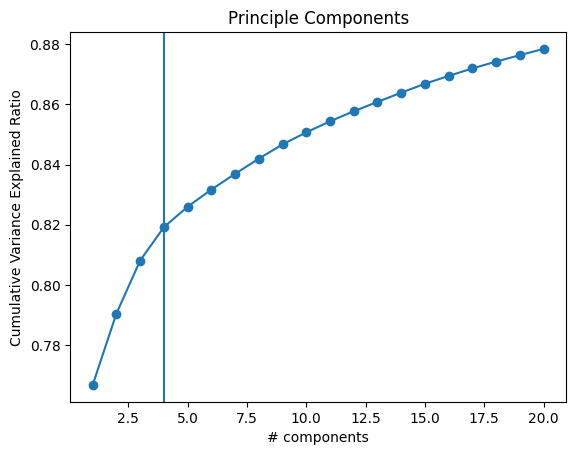

In [ ]:
num_com = 4 #best since others overfit
plt.plot(range(1, 21), np.cumsum(pca.explained_variance_ratio_[:20]), 'o-')
plt.axvline(x=num_com)
plt.xlabel('# components')
plt.ylabel('Cumulative Variance Explained Ratio')
plt.title('Principle Components');

Apply PCA using chosen number of components.

In [ ]:
pca = PCA(num_com).fit(x_train_scaled_cnn)
x_train_scaled_cnn_pca = pd.DataFrame(pca.transform(x_train_scaled_cnn), columns=[f"com_{i}" for i in range(num_com)])
x_val_scaled_cnn_pca = pd.DataFrame(pca.transform(x_val_scaled_cnn), columns=[f"com_{i}" for i in range(num_com)])

x_train_scaled_pca = pd.concat([x_train_scaled,x_train_scaled_cnn_pca], axis=1)
x_val_scaled_pca = pd.concat([x_val_scaled,x_val_scaled_cnn_pca], axis=1)

First explore different models trying to fit without image features.

In [ ]:
dt = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid={'max_depth': range(1,20)},
                  cv=5).fit(x_train_scaled, y_train)

cv_score = cross_val_score(dt, x_train_scaled, y_train, scoring='r2', cv=5)

dt.score(x_train_scaled, y_train), cv_score.mean(), dt.score(x_val_scaled, y_val)

(0.9843629356712171, 0.8002204313685043, 0.8054841732510433)

In [ ]:
#get best depth from best decision tree
best_depth = dt.best_params_['max_depth']
print(best_depth)

16


In [ ]:
#winner here with highest R2 on test data!
rf = RandomForestRegressor(max_depth=2*best_depth,
                           n_estimators=500,
                           max_features='sqrt',
                           oob_score=True,
                           random_state=123).fit(x_train_scaled, y_train)

cv_score = cross_val_score(rf, x_train_scaled, y_train, scoring='r2', cv=5)

rf.score(x_train_scaled, y_train), cv_score.mean(), rf.score(x_val_scaled, y_val)

(0.9823319124250162, 0.8699941664319691, 0.8859920166374474)

In [ ]:
rf2 = RandomForestRegressor(max_depth=best_depth,
                           n_estimators=500,
                           max_features='sqrt',
                           oob_score=True,
                           random_state=123).fit(x_train_scaled, y_train)

cv_score = cross_val_score(rf2, x_train_scaled, y_train, scoring='r2', cv=5)

rf2.score(x_train_scaled, y_train), cv_score.mean(), rf2.score(x_val_scaled, y_val)

(0.967955945262825, 0.8668736021703249, 0.8791098527017788)

In [ ]:
gb = GradientBoostingRegressor(n_estimators=500,
                               max_depth=2*best_depth,
                               random_state=123).fit(x_train_scaled, y_train)

cv_score = cross_val_score(gb, x_train_scaled, y_train, scoring='r2', cv=5)

gb.score(x_train_scaled, y_train), cv_score.mean(), gb.score(x_val_scaled, y_val)

(0.9990093759017529, 0.8153767927100434, 0.8080437062661711)

In [ ]:
gb2 = GradientBoostingRegressor(n_estimators=500,
                               max_depth=best_depth,
                               random_state=123).fit(x_train_scaled, y_train)

cv_score = cross_val_score(gb2, x_train_scaled, y_train, scoring='r2', cv=5)

gb2.score(x_train_scaled, y_train), cv_score.mean(), gb2.score(x_val_scaled, y_val)

(0.9990091487464836, 0.8357877046983239, 0.8187156275593419)

Now try models including image features with PCA.

In [ ]:
dt_pca = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid={'max_depth': range(1,20)},
                  cv=5).fit(x_train_scaled_pca, y_train)

cv_score = cross_val_score(dt_pca, x_train_scaled_pca, y_train, scoring='r2', cv=5)

dt_pca.score(x_train_scaled_pca, y_train), cv_score.mean(), dt_pca.score(x_val_scaled_pca, y_val)

(0.9439519889791114, 0.7814071342305807, 0.8197865906978916)

In [ ]:
best_depth_pca = dt_pca.best_params_['max_depth']
print(best_depth_pca)

12


In [ ]:
rf_pca = RandomForestRegressor(max_depth=2*best_depth_pca,
                           n_estimators=500,
                           max_features='sqrt',
                           oob_score=True,
                           random_state=123).fit(x_train_scaled_pca, y_train)

cv_score = cross_val_score(rf_pca, x_train_scaled_pca, y_train, scoring='r2', cv=5)

rf_pca.score(x_train_scaled_pca, y_train), cv_score.mean(), rf_pca.score(x_val_scaled_pca, y_val)

(0.9791569193866932, 0.8409200923337978, 0.8730454013147179)

In [ ]:
rf2_pca = RandomForestRegressor(max_depth=best_depth_pca,
                           n_estimators=500,
                           max_features='sqrt',
                           oob_score=True,
                           random_state=123).fit(x_train_scaled_pca, y_train)

cv_score = cross_val_score(rf2_pca, x_train_scaled_pca, y_train, scoring='r2', cv=5)

rf2_pca.score(x_train_scaled_pca, y_train), cv_score.mean(), rf2_pca.score(x_val_scaled_pca, y_val)

(0.9242388695547061, 0.8097291744051051, 0.842652554431844)

In [ ]:
gb_pca = GradientBoostingRegressor(n_estimators=500,
                               max_depth=2*best_depth_pca,
                               random_state=123).fit(x_train_scaled_pca, y_train)

cv_score = cross_val_score(gb_pca, x_train_scaled_pca, y_train, scoring='r2', cv=5)

gb_pca.score(x_train_scaled_pca, y_train), cv_score.mean(), gb_pca.score(x_val_scaled_pca, y_val)

(0.9997657343097573, 0.791398376460537, 0.8287715333505414)

In [ ]:
#winning model when include image features
gb2_pca = GradientBoostingRegressor(n_estimators=500,
                               max_depth=best_depth_pca,
                               random_state=123).fit(x_train_scaled_pca, y_train)

cv_score = cross_val_score(gb2_pca, x_train_scaled_pca, y_train, scoring='r2', cv=5)

gb2_pca.score(x_train_scaled_pca, y_train), cv_score.mean(), gb2_pca.score(x_val_scaled_pca, y_val)

(0.9996219268377537, 0.8492443415788056, 0.8793279557296546)

Now that selected best model with and without image features, refit with all the data and then pickle models.

In [10]:
cnn_features_lst = list(cnn_features.columns)
cnn_features_lst.append('SOLDPRICE')

best_depth = 16

#fit final selected model without CNN features and w/ all data
x = data.drop(cnn_features_lst, axis=1)
y = data.SOLDPRICE

pipe = Pipeline([('scaler', StandardScaler()),
                 ('rf', RandomForestRegressor(max_depth=2*best_depth,
                           n_estimators=500,
                           max_features='sqrt',
                           oob_score=True,
                           random_state=123))])

pipe.fit(x,y)
pipe.score(x,y)

0.9832184443854469

In [13]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [ ]:
with bz2.BZ2File('best_model.pbz2', 'wb') as f:
    pickle.dump(pipe, f)

In [14]:
from sklearn.compose import ColumnTransformer

best_depth = 12
num_comp = 4

#fit final selected model w/ CNN features and w/ all data
x = data.drop('SOLDPRICE', axis=1)
y = data.SOLDPRICE

#apply PCA only on image features and allow other variables to pass through
pca_transformer = ColumnTransformer([('pca', PCA(num_comp),
                                      [i for i in range(38,2056)])], remainder='passthrough')

pipe_pca = Pipeline([('scaler', StandardScaler()),
                     ('pca', pca_transformer),
                     ('gb', GradientBoostingRegressor(n_estimators=500,
                               max_depth=best_depth,
                               random_state=123))])

pipe_pca.fit(x,y)
pipe_pca.score(x,y)

0.9995552399681134

In [ ]:
with bz2.BZ2File('best_model_cnn.pbz2', 'wb') as f:
    pickle.dump(pipe_pca, f)

In [16]:
with open('best_model_cnn.pkl', 'wb') as f:
    pickle.dump(pipe_pca, f)